In [ ]:
# Importing Standard Libraries
!pip install torchvision
!pip install torchsummary

import os  # For operating system-related tasks, such as file and directory management
import random  # For generating random numbers, useful for creating randomized datasets
from tqdm.notebook import tqdm  # For displaying progress bars in Jupyter Notebooks

# Data manipulation and visualization
import matplotlib.pyplot as plt  # For creating static, animated, and interactive visualizations in Python
from PIL import Image  # For opening, manipulating, and saving many different image file formats
import seaborn as sns  # For making statistical graphics in Python
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical computations and handling arrays

# Deep Learning libraries
import torch  # The main PyTorch library for building and training neural networks
import torchvision  # A PyTorch library containing popular datasets, model architectures, and image transformations
import torchsummary  # For printing a summary of the model architecture
from torch.utils.data import Dataset, DataLoader, Subset  # For creating custom datasets and data loaders
from torchvision import datasets, models, transforms  # For dataset handling, model architectures, and image transformations
from sklearn.metrics import confusion_matrix, accuracy_score  # For evaluating model performance
import itertools  # For creating iterators for efficient looping


In [ ]:
# Set seed for reproducibility
# Setting a seed ensures that the results are consistent and reproducible each time the code is run.
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Check if GPU is enabled
# PyTorch allows for the use of GPU to speed up training. Here we check if a GPU is available and set the device accordingly.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
if device.type == 'cuda':
    # If a GPU is available, print the name of the GPU
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Device: cuda:0
GPU: Tesla T4


In [ ]:
import requests

# Download the EuroSAT dataset ZIP file
url = 'http://madm.dfki.de/files/sentinel/EuroSAT.zip'
response = requests.get(url)

# Save the file as 'EuroSAT.zip'
with open('EuroSAT.zip', 'wb') as f:
    f.write(response.content)

print("Dataset downloaded successfully.")


Dataset downloaded successfully.


In [ ]:
import zipfile
import os

# Create the directory where the dataset will be extracted
os.makedirs('EuroSAT', exist_ok=True)

# Unzip the downloaded dataset
with zipfile.ZipFile('EuroSAT.zip', 'r') as zip_ref:
    zip_ref.extractall('EuroSAT')

print("Dataset unzipped successfully.")


Dataset unzipped successfully.


In [ ]:
# Remove the ZIP file
os.remove('EuroSAT.zip')

print("ZIP file removed successfully.")


ZIP file removed successfully.


In [ ]:
import torch
from torch.utils.data import Dataset

class EuroSAT(Dataset):

    def __init__(self, dataset, transform=None):
        self.dataset = dataset  # Store the dataset
        self.transform = transform  # Store the optional transformation function

    def __getitem__(self, index):

        image, label = self.dataset[index]  # Get the image and label from the dataset at the specified index

        if self.transform:
            image = self.transform(image)  # Apply the transformation if provided

        return image, label  # Return the image and label

    def __len__(self):
        """
        Get the number of items in the dataset.

        Returns:
        - The length of the dataset (number of items).
        """
        return len(self.dataset)  # Return the length of the dataset


In [ ]:
input_size = 224
imagenet_mean, imagenet_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(input_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

test_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])


In [ ]:
# Define the directory where the dataset images are stored
data_dir = './EuroSAT/2750/'

# Create an ImageFolder dataset instance for the specified directory
dataset = datasets.ImageFolder(data_dir)

# Extract and print the class names from the dataset
class_names = dataset.classes
print(f"Class names: {class_names}")

# Print the total number of classes in the dataset
print(f"Total number of classes: {len(class_names)}")

# Define the proportion of the dataset to be used for training
train_size = 0.8

# Generate a list of indices for all data points in the dataset
indices = list(range(len(dataset)))

# Calculate the split index for training and testing data
split = int(train_size * len(dataset))

# Shuffle the indices to randomize the dataset split
np.random.shuffle(indices)

# Split the indices into training and testing indices
train_indices, test_indices = indices[:split], indices[split:]

# Create subsets of the dataset for training and testing using the indices
train_data = EuroSAT(Subset(dataset, train_indices), train_transform)
test_data = EuroSAT(Subset(dataset, test_indices), test_transform)

# Define the batch size and the number of workers for data loading
batch_size = 16
num_workers = 2

# Create DataLoader instances for training and testing data
# Shuffle training data to ensure randomness during training
train_loader = DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)

# Do not shuffle testing data; it's used for evaluation
test_loader = DataLoader(test_data, batch_size=batch_size, num_workers=num_workers, shuffle=False)


Class names: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Total number of classes: 10


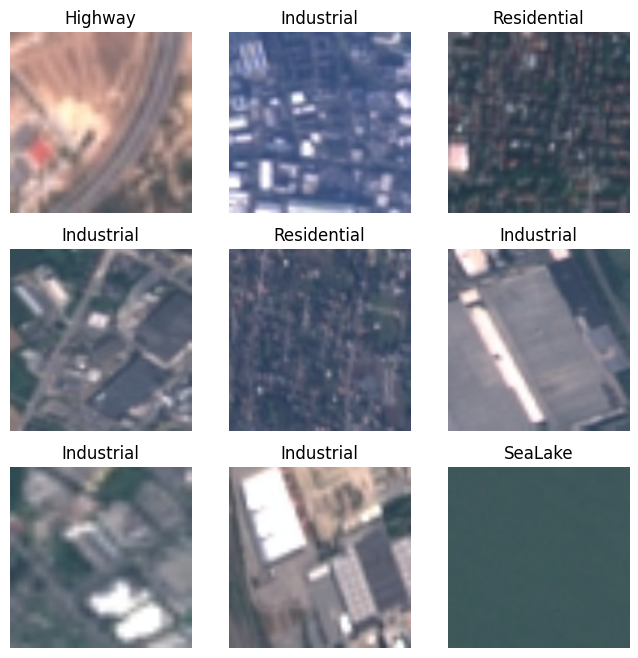

In [ ]:
def show_sample_images(dataloader, class_names, n=3):

    # Get a batch of images and labels from the dataloader
    inputs, classes = next(iter(dataloader))

    # Create a figure with subplots arranged in an n x n grid
    fig, axes = plt.subplots(n, n, figsize=(8, 8))

    # Iterate over each subplot position in the grid
    for i in range(n):
        for j in range(n):
            # Get the image from the batch and convert from CHW to HWC format
            image = inputs[i * n + j].numpy().transpose((1, 2, 0))

            # Reverse the normalization of the image (assuming imagenet_std and imagenet_mean are defined)
            image = np.clip(np.array(imagenet_std) * image + np.array(imagenet_mean), 0, 1)

            # Get the class name for the current image
            title = class_names[classes[i * n + j]]

            # Display the image in the current subplot
            axes[i, j].imshow(image)
            axes[i, j].set_title(title)  # Set the title of the subplot to the class name
            axes[i, j].axis('off')  # Hide the axis for a cleaner look

    # Show the plot with the grid of images
    plt.show()

# Call the function to display sample images from the train_loader
show_sample_images(train_loader, class_names)



In [ ]:

model = models.resnet50(pretrained=True)

model.fc = torch.nn.Linear(model.fc.in_features, len(class_names))


model = model.to(device)


torchsummary.summary(model, (3, 224, 224))


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 54.3MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:

criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [ ]:
def train(model, dataloader, criterion, optimizer, device):
    # Set the model to training mode
    model.train()

    # Initialize running totals for loss and correct predictions
    running_loss = 0.0
    running_corrects = 0

    # Loop over data batches in the dataloader
    for inputs, labels in tqdm(dataloader):
        # Move inputs and labels to the specified device (e.g., GPU or CPU)
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients to avoid accumulation
        optimizer.zero_grad()

        # Forward pass: compute outputs by passing inputs to the model
        outputs = model(inputs)

        # Compute the loss between model outputs and actual labels
        loss = criterion(outputs, labels)

        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # Update model parameters based on the computed gradients
        optimizer.step()

        # Get the predicted class with the highest score
        _, preds = torch.max(outputs, 1)

        # Update the running loss (scaled by the batch size)
        running_loss += loss.item() * inputs.size(0)

        # Update the count of correct predictions
        running_corrects += torch.sum(preds == labels.data)

    # Calculate average loss and accuracy for the epoch
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)

    # Return the average loss and accuracy for the epoch
    return epoch_loss, epoch_acc

In [ ]:
def evaluate(model, dataloader, criterion, device):
    # Set the model to evaluation mode
    model.eval()

    # Initialize variables to track loss, correct predictions, and store all predictions and labels
    running_loss = 0.0
    running_corrects = 0
    all_preds = []
    all_labels = []

    # Disable gradient computation for evaluation
    with torch.no_grad():
        # Iterate over the data in the dataloader
        for inputs, labels in tqdm(dataloader):
            # Move inputs and labels to the specified device (CPU or GPU)
            inputs, labels = inputs.to(device), labels.to(device)

            # Perform forward pass to get outputs from the model
            outputs = model(inputs)

            # Calculate the loss
            loss = criterion(outputs, labels)

            # Get the predicted class by finding the index with the highest score
            _, preds = torch.max(outputs, 1)

            # Update the running loss and correct predictions count
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            # Store predictions and labels for later use (e.g., for metrics computation)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate average loss and accuracy over the entire dataset
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)

    # Return the computed metrics
    return epoch_loss, epoch_acc, all_labels, all_preds

In [ ]:
# Initialize the best model weights to the current state of the model
best_model_wts = model.state_dict()

# Set the best loss to infinity initially so that any loss will be lower
best_loss = float('inf')

# Set the number of epochs to train the model
num_epochs = 3

# Loop over the dataset multiple times (each loop is one epoch)
for epoch in range(num_epochs):
    # Print the current epoch number
    print(f"Epoch {epoch+1}/{num_epochs}")

    # Train the model and get the training loss and accuracy
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)

    # Print the training loss and accuracy for the current epoch
    print(f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}")

    # Evaluate the model on the validation set and get the loss, accuracy, all labels, and all predictions
    val_loss, val_acc, all_labels, all_preds = evaluate(model, test_loader, criterion, device)

    # Print the validation loss and accuracy for the current epoch
    print(f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

    # If the current validation loss is lower than the best loss seen so far
    if val_loss < best_loss:
        # Update the best loss to the current validation loss
        best_loss = val_loss
        # Save the model weights as the best model weights
        best_model_wts = model.state_dict()

# Load the best model weights into the model
model.load_state_dict(best_model_wts)

# Define the directory where the model will be saved
model_dir = "./drive/My Drive/Colab Notebooks/models/"

# Create the directory if it does not exist
os.makedirs(model_dir, exist_ok=True)

# Define the file path for saving the best model weights
model_file = os.path.join(model_dir, 'best_model.pth')

# Save the best model weights to the file
torch.save(model.state_dict(), model_file)

# Print a message indicating that the model has been saved
print(f'Model saved to {model_file}')


Epoch 1/3


  0%|          | 0/1350 [00:00<?, ?it/s]

Train Loss: 0.9840 Acc: 0.7173


  0%|          | 0/338 [00:00<?, ?it/s]

Val Loss: 0.2965 Acc: 0.9222
Epoch 2/3


  0%|          | 0/1350 [00:00<?, ?it/s]

Train Loss: 0.4515 Acc: 0.8565


  0%|          | 0/338 [00:00<?, ?it/s]

Val Loss: 0.1616 Acc: 0.9552
Epoch 3/3


  0%|          | 0/1350 [00:00<?, ?it/s]

Train Loss: 0.3569 Acc: 0.8851


  0%|          | 0/338 [00:00<?, ?it/s]

Val Loss: 0.1234 Acc: 0.9648
Model saved to ./drive/My Drive/Colab Notebooks/models/best_model.pth


## Loading the Best Model for Evaluation




In [ ]:
# Load a pre-trained ResNet-50 model
model = models.resnet50(pretrained=True)

model.fc = torch.nn.Linear(model.fc.in_features, len(class_names))

# Load the trained model weights from a file
# 'model_file' is the path to the file containing the model weights
model.load_state_dict(torch.load(model_file))

model = model.to(device)


model.eval()


<ipython-input-15-9a73034ff1dd>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_file))


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Plotting the Confusion Matrix



Confusion matrix, without normalization
Overall accuracy: 0.9648


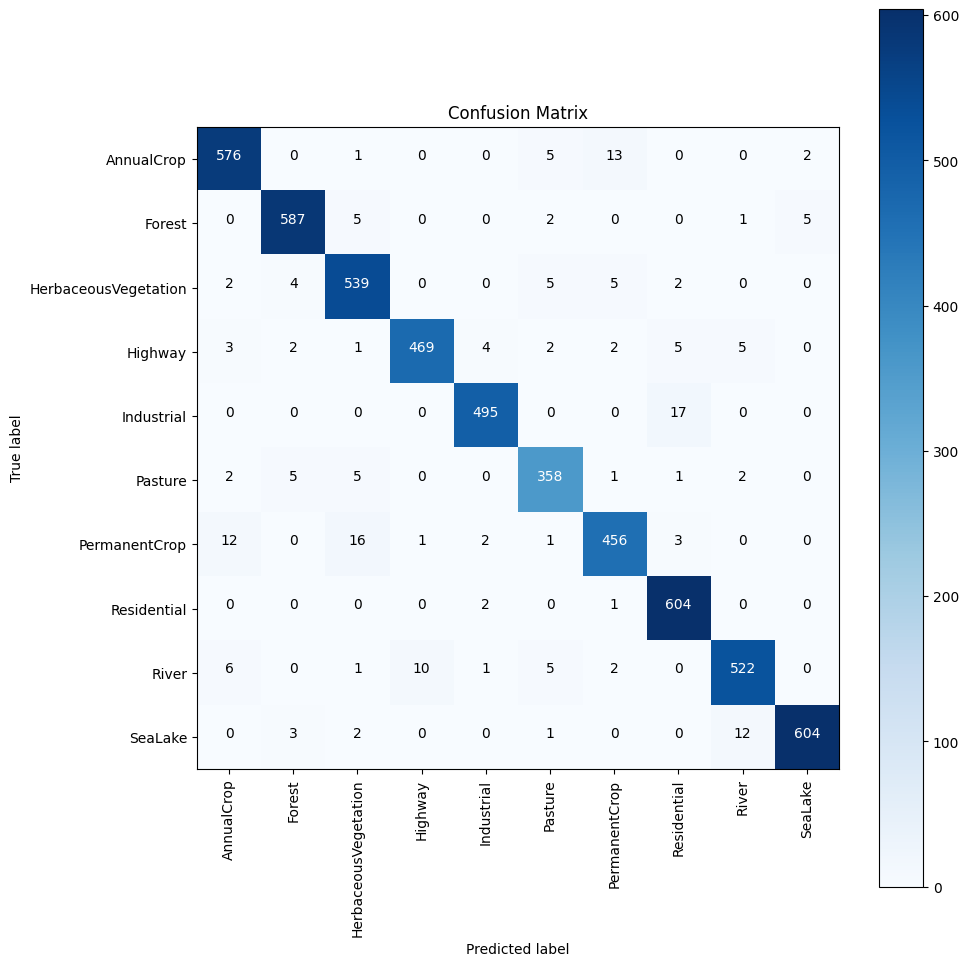

In [ ]:
# Function to plot the confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    # If normalization is set to True, normalize the confusion matrix
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Print a message indicating whether the confusion matrix is normalized or not
    print("Confusion matrix, without normalization" if not normalize else "Normalized confusion matrix")

    # Create a new figure with a specified size
    plt.figure(figsize=(10, 10))
    # Display the confusion matrix as an image
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    # Set the title of the plot
    plt.title(title)
    # Add a color bar to the side of the plot
    plt.colorbar()
    # Set tick marks at each class index
    tick_marks = np.arange(len(classes))
    # Label the x-axis ticks with the class names, rotated 90 degrees
    plt.xticks(tick_marks, classes, rotation=90)
    # Label the y-axis ticks with the class names
    plt.yticks(tick_marks, classes)

    # Format the values in the confusion matrix as float with 2 decimals if normalized, otherwise as integers
    fmt = '.2f' if normalize else 'd'
    # Determine a threshold to change text color for better readability
    thresh = cm.max() / 2.
    # Iterate through each cell in the confusion matrix
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        # Place the text in the middle of each cell
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    # Adjust the layout for better fit
    plt.tight_layout()
    # Label the y-axis as 'True label'
    plt.ylabel('True label')
    # Label the x-axis as 'Predicted label'
    plt.xlabel('Predicted label')

# Calculate and plot the confusion matrix
# `all_labels` contains the true labels and `all_preds` contains the predicted labels
cm = confusion_matrix(all_labels, all_preds)
# `class_names` contains the list of class names
plot_confusion_matrix(cm, class_names, title='Confusion Matrix')

# Calculate the overall accuracy of the model
accuracy = accuracy_score(all_labels, all_preds)
# Print the overall accuracy
print(f'Overall accuracy: {accuracy:.4f}')


## Making Predictions on Sample Images




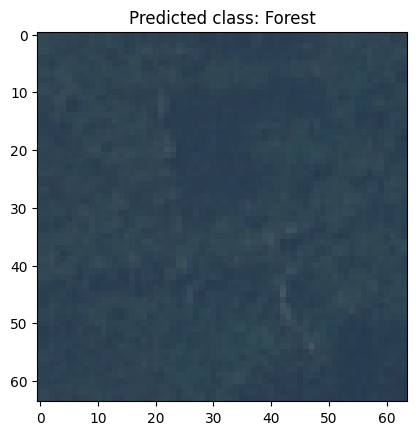

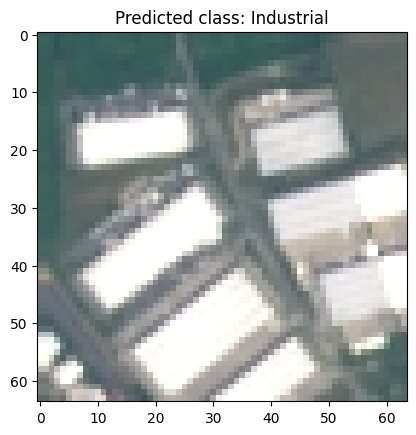

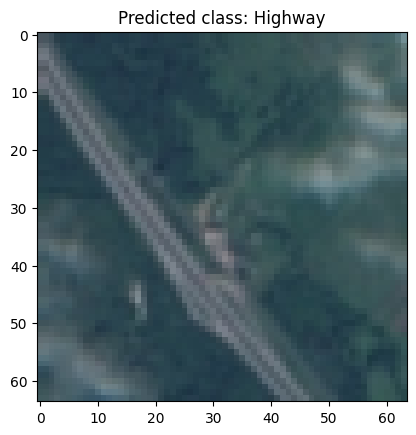

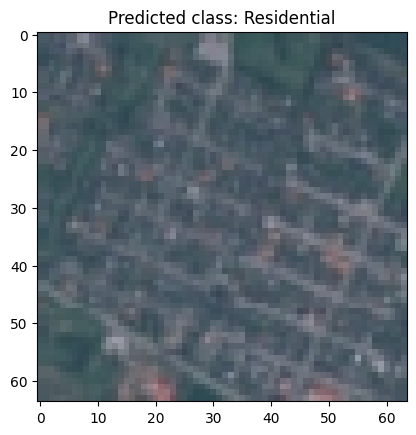

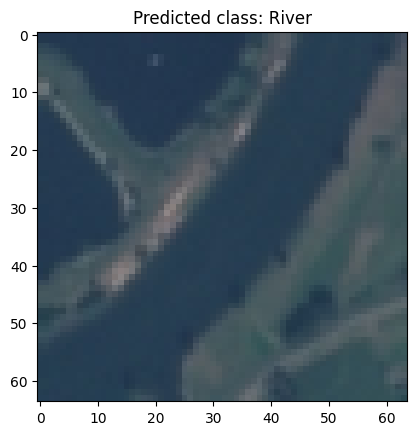

In [ ]:
def predict_image(image, model, class_names, device):
    # Set the model to evaluation mode
    model.eval()
    with torch.no_grad():  # Disable gradient computation for faster inference
        # Move the image to the specified device (CPU or GPU) and make predictions
        outputs = model(image.to(device))
        # Get the predicted class by finding the index with the highest score
        _, preds = torch.max(outputs, 1)
    # Return the name of the predicted class
    return class_names[preds.item()]

# Predict on a single sample image
image_path = './EuroSAT/2750/Forest/Forest_10.jpg'
image = Image.open(image_path)  # Open the image file
input_image = test_transform(image).unsqueeze(0).to(device)  # Apply transformations and add batch dimension
pred_class = predict_image(input_image, model, class_names, device)  # Predict the class of the image

# Display the image along with the predicted class
fig, ax = plt.subplots()
ax.imshow(image)
ax.set_title(f"Predicted class: {pred_class}")
plt.show()

# Predict on multiple sample images
sample_image_paths = [
    './EuroSAT/2750/Industrial/Industrial_10.jpg',
    './EuroSAT/2750/Highway/Highway_10.jpg',
    './EuroSAT/2750/Residential/Residential_10.jpg',
    './EuroSAT/2750/River/River_10.jpg'
]

for image_path in sample_image_paths:
    image = Image.open(image_path)  # Open the image file
    input_image = test_transform(image).unsqueeze(0).to(device)  # Apply transformations and add batch dimension
    pred_class = predict_image(input_image, model, class_names, device)  # Predict the class of the image

    # Display the image along with the predicted class
    fig, ax = plt.subplots()
    ax.imshow(image)
    ax.set_title(f"Predicted class: {pred_class}")
    plt.show()


In [ ]:
from PIL import Image
import numpy as np

def calculate_green_percentage(image):
    """
    Calculate the percentage of green pixels in an image.

    Parameters:
    - image: A PIL Image object.

    Returns:
    - green_percentage: The percentage of green pixels in the image.
    """
    # Convert image to RGB and then to a NumPy array
    image_array = np.array(image)

    # Define the range for detecting green
    green_mask = (image_array[:, :, 1] > 100) & (image_array[:, :, 0] < 100) & (image_array[:, :, 2] < 100)

    # Calculate total number of pixels and green pixels
    total_pixels = image_array.shape[0] * image_array.shape[1]
    green_pixels = np.sum(green_mask)

    # Calculate percentage of green pixels
    green_percentage = (green_pixels / total_pixels) * 100

    return green_percentage

def classify_devegetation_zone(image, predicted_class, green_classes, threshold=30):
    """
    Classify the image as a 'devegetation zone' if it has less than 30% green area.

    Parameters:
    - image: A PIL Image object.
    - predicted_class: The predicted class of the image.
    - green_classes: List of classes that are related to vegetation.
    - threshold: The percentage threshold to classify as 'devegetation zone' (default is 30%).

    Returns:
    - classification: 'devegetation zone' or 'normal'.
    """
    if predicted_class in green_classes:
        # Calculate green coverage percentage
        green_percentage = calculate_green_percentage(image)

        # If green area is less than the threshold, classify as 'devegetation zone'
        if green_percentage < threshold:
            return 'devegetation zone'
        else:
            return 'normal'
    else:
        # If the predicted class isn't related to vegetation, it's not a deforestation concern
        return 'normal'

# Example usage
image_path = './EuroSAT/2750/Industrial/Industrial_10.jpg'
image = Image.open(image_path)

# Assuming class 2, 4, 5 represent vegetation/forest
green_classes = [1,2, 3,4,7,10]  # Example: vegetation-related classes
predicted_class = 4  # Example predicted class (forest)

# Classify the image based on green coverage
classification = classify_devegetation_zone(image, predicted_class, green_classes)

print(f"Classification: {classification}")


Classification: devegetation zone


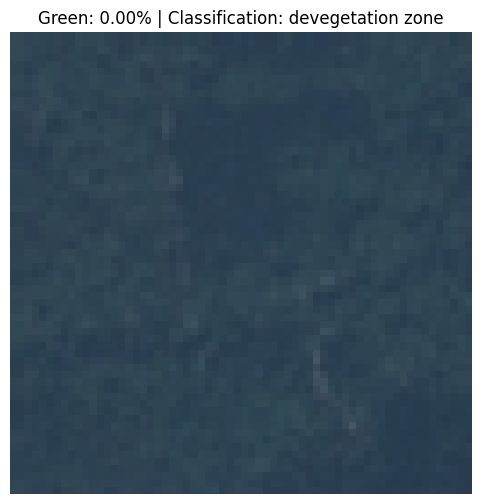

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def calculate_green_percentage(image):
    """
    Calculate the percentage of green pixels in an image.

    Parameters:
    - image: A PIL Image object.

    Returns:
    - green_percentage: The percentage of green pixels in the image.
    """
    # Convert image to RGB and then to a NumPy array
    image_array = np.array(image)

    # Define the range for detecting green
    green_mask = (image_array[:, :, 1] > 100) & (image_array[:, :, 0] < 100) & (image_array[:, :, 2] < 100)

    # Calculate total number of pixels and green pixels
    total_pixels = image_array.shape[0] * image_array.shape[1]
    green_pixels = np.sum(green_mask)

    # Calculate percentage of green pixels
    green_percentage = (green_pixels / total_pixels) * 100

    return green_percentage

def classify_and_visualize(image, predicted_class, green_classes, threshold=30):
    """
    Classify the image as 'devegetation zone' or 'normal', and visualize the result.

    Parameters:
    - image: A PIL Image object.
    - predicted_class: The predicted class of the image.
    - green_classes: List of classes related to vegetation.
    - threshold: The percentage threshold to classify as 'devegetation zone' (default is 30%).

    Visualizes:
    - The image with green percentage and classification result overlaid.
    """
    green_percentage = calculate_green_percentage(image)

    if predicted_class in green_classes:
        # If green area is less than the threshold, classify as 'devegetation zone'
        if green_percentage < threshold:
            classification = 'devegetation zone'
        else:
            classification = 'normal'
    else:
        classification = 'normal'

    # Visualize the image with overlayed information
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.title(f"Green: {green_percentage:.2f}% | Classification: {classification}")
    plt.axis('off')  # Hide axis
    plt.show()

# Example usage
image_path = './EuroSAT/2750/Forest/Forest_10.jpg'
image = Image.open(image_path)

# Assuming class 2, 4, 5 represent vegetation/forest
green_classes = [1,2,3, 4, 7,10]  # Example: vegetation-related classes
predicted_class = 4  # Example predicted class (forest)

# Classify and visualize the result
classify_and_visualize(image, predicted_class, green_classes)


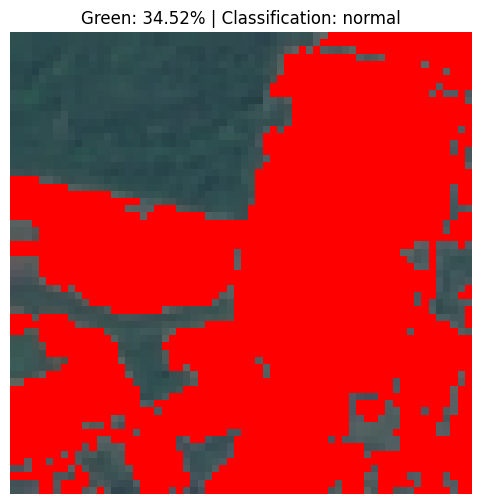

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def calculate_green_percentage(image, green_threshold=(60, 150)):
    """
    Calculate the percentage of green pixels in an image with adjusted green thresholds.

    Parameters:
    - image: A PIL Image object.
    - green_threshold: Tuple defining the min and max values for the green channel (default is (60, 150)).

    Returns:
    - green_percentage: The percentage of green pixels in the image.
    - green_mask: A mask showing the green pixels.
    """
    # Convert image to RGB and then to a NumPy array
    image_array = np.array(image)

    # Adjust thresholds for detecting vivid green
    min_green, max_green = green_threshold
    green_mask = (image_array[:, :, 1] > min_green) & (image_array[:, :, 1] < max_green) & \
                 (image_array[:, :, 0] < 100) & (image_array[:, :, 2] < 100)

    # Calculate total number of pixels and green pixels
    total_pixels = image_array.shape[0] * image_array.shape[1]
    green_pixels = np.sum(green_mask)

    # Calculate percentage of green pixels
    green_percentage = (green_pixels / total_pixels) * 100

    return green_percentage, green_mask

def classify_and_visualize(image, predicted_class, green_classes, threshold=30, green_threshold=(60, 150)):
    """
    Classify the image as 'devegetation zone' or 'normal', and visualize the result with better green detection.

    Parameters:
    - image: A PIL Image object.
    - predicted_class: The predicted class of the image.
    - green_classes: List of classes related to vegetation.
    - threshold: The percentage threshold to classify as 'devegetation zone' (default is 30%).
    - green_threshold: Tuple for adjusting green color thresholds.

    Visualizes:
    - The image with green percentage and classification result overlaid.
    """
    green_percentage, green_mask = calculate_green_percentage(image, green_threshold)

    if predicted_class in green_classes:
        # If green area is less than the threshold, classify as 'devegetation zone'
        if green_percentage < threshold:
            classification = 'devegetation zone'
        else:
            classification = 'normal'
    else:
        classification = 'normal'

    # Visualize the image with green and non-green areas marked
    image_array = np.array(image)
    marked_image = image_array.copy()

    # Mark non-green areas with a distinct color (e.g., red)
    marked_image[~green_mask] = [255, 0, 0]  # Mark non-green pixels as red

    # Show the image with green and non-green areas
    plt.figure(figsize=(6, 6))
    plt.imshow(marked_image)
    plt.title(f"Green: {green_percentage:.2f}% | Classification: {classification}")
    plt.axis('off')  # Hide axis
    plt.show()

# Example usage
image_path = './EuroSAT/2750/Industrial/Industrial_1.jpg'
image = Image.open(image_path)

# Assuming class 2, 4, 5 represent vegetation/forest
green_classes = [1,2,3, 4, 7,10]  # Example: vegetation-related classes
predicted_class = 4  # Example predicted class (forest)

# Classify and visualize the result with better green detection
classify_and_visualize(image, predicted_class, green_classes, green_threshold=(60, 200))
